In [369]:
import requests
import math
from datetime import datetime, timezone, timedelta
import pandas as pd
from pandas.io.json import json_normalize
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import numpy as np

In [470]:
year_start = 2017
month_start = 1
day_start = 1
hour_start = 0

year_end = 2018
month_end = 1
day_end = 1
hour_end = 0

crypto = 'ethereum'
fsym = 'ETH'
tsym = 'USD'

In [460]:
prices_df = pd.DataFrame()

start_date = datetime(year_start, month_start, day_start, hour_start, tzinfo=timezone.utc)
end_date = datetime(year_end, month_end, day_end, hour_end, tzinfo=timezone.utc)
date_iterator = start_date - timedelta(hours=1)

while date_iterator < end_date:
    delta = timedelta(seconds=min((end_date - date_iterator).total_seconds(), 2000 * 3600))
    date_iterator += delta
    params={
        'fsym': fsym,
        'tsym': tsym,
        'limit': delta.total_seconds() // 3600 - 1,
        'toTs': date_iterator.timestamp()
    }
    r = requests.get('https://min-api.cryptocompare.com/data/histohour', params=params)
    prices_df = pd.concat([prices_df, json_normalize(r.json(), record_path="Data")])

prices_df['time'] = pd.to_datetime(prices_df['time'], unit='s')
prices_df.set_index('time', inplace=True)
prices_df = prices_df.tz_localize('UTC')

In [461]:
pytrends = TrendReq()

trends_df = pytrends.get_historical_interest([crypto],
                                             year_start=year_start,
                                             month_start=month_start,
                                             day_start=day_start,
                                             hour_start=hour_start,
                                             year_end=year_end,
                                             month_end=month_end,
                                             day_end=day_end+7,
                                             hour_end=hour_end)

trends_df.rename(columns={crypto: 'searches'}, inplace=True)

trends_df = trends_df.tz_localize('UTC')

delta = timedelta(days=7)
date_iterator = start_date + delta

while date_iterator < end_date:
    overlap = trends_df[trends_df.index == date_iterator]
    ratio = overlap.iloc[0]['searches'] / overlap.iloc[-1]['searches']
    trends_df.loc[trends_df.index < date_iterator, 'searches'] /= ratio
    date_iterator += delta
    
trends_df = trends_df[~trends_df.index.duplicated(keep='last')]
trends_df['searches'] *= 100 / np.max(trends_df['searches'])

In [462]:
df = prices_df.join(trends_df, how='inner')

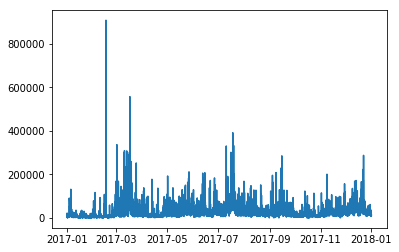

In [476]:
plt.plot(df.index.values, df['volumefrom'])